In [102]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import harmonypy as hm

In [17]:
import celloracle as co
co.__version__

'0.20.0'

In [18]:
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [19]:
save_folder = "CellOracle_figures"
os.makedirs(save_folder, exist_ok=True)


In [103]:
adata = sc.read_h5ad("/home/hjlee/RCC_upload_final_raw_counts.h5ad")
adata

AnnData object with n_obs × n_vars = 270855 × 19736
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type'
    var: 'name'
    uns: 'annotation_colors', 'broad_type_colors', 'region_colors', 'summaryDescription_colors'
    obsm: 'X_pca', 'X_umap'

In [104]:
want = ['Blood', 'Fat', 'Thrombus']
adata = adata[~adata.obs['summaryDescription'].isin(want)].copy()
keep_genes = ~adata.var_names.str.startswith('RP')
adata = adata[:, keep_genes].copy()
adata.obs["tissue_major"] = adata.obs["summaryDescription"].astype(str) + "__" + adata.obs["broad_type"].astype(str)
combined = adata.obs["summaryDescription"].astype(str) + "__" + adata.obs["broad_type"].astype(str)
value_counts = combined.value_counts()
keep = value_counts[value_counts > 100].index.tolist()
adata = adata[adata.obs['tissue_major'].isin(keep)].copy()
adata

AnnData object with n_obs × n_vars = 203847 × 17850
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type', 'tissue_major'
    var: 'name'
    uns: 'annotation_colors', 'broad_type_colors', 'region_colors', 'summaryDescription_colors'
    obsm: 'X_pca', 'X_umap'

In [105]:
subsets = []
np.random.seed(1)

for bt in adata.obs["broad_type"].unique():
    subset = adata[adata.obs["broad_type"] == bt]

    if subset.n_obs > 15000:
        sampled_idx = np.random.choice(subset.obs_names, 15000, replace=False)
        subset = subset[sampled_idx, :]

    subsets.append(subset)

adata = subsets[0].concatenate(*subsets[1:], join="outer")
adata

AnnData object with n_obs × n_vars = 75700 × 17850
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type', 'tissue_major', 'batch'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [106]:
# 1. Variable gene selection and normalization.
# 2. Log transformation. Like many preprocessing workflows, we need to log transform the data. 
# However, CellOracle also needs the raw gene expression values, which we will store in an anndata layer.
# 3. Cell clustering.
# 4. Dimensional reduction. We need to prepare the 2D embedding data. 
# Please make sure that the 2D embedding properly represents the cell identities and processes of interest. Also, please consider the resolution and continuity of the data. 
# CellOracle’s simulation results are only informative when the embedding is consistent with the questions being investigated.

sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata, target_sum=1e4) # total count correction 
adata.layers["raw_count"] = adata.X.copy()
# Step 4. Store raw (for later inspection)
adata.raw = adata.copy()
sc.pp.log1p(adata) # log(x+1) transformation
# Select top 2000 highly-variable genes
filter_result = sc.pp.highly_variable_genes(adata,
                                            flavor='seurat',
                                            n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 75700 × 17804
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type', 'tissue_major', 'batch'
    var: 'name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'raw_count'

In [108]:
# Subset the genes using HVG
adata = adata[:, adata.var['highly_variable']]
# Step 7. Scale
sc.pp.scale(adata)
# Step 8. PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
# Harmony input: PCA 결과와 batch 변수 (여기서는 'patient')
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, vars_use=['patient'])
# Harmony 결과를 새로 저장
adata.obsm['X_pca_harmony'] = ho.Z_corr.T
# Neighbors 및 UMAP → Harmony 기반으로 다시 수행
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
# Step 10. Diffusion map
sc.tl.diffmap(adata)
# Step 12. Clustering
sc.tl.leiden(adata, resolution=0.5, random_state=777)

2025-05-31 19:25:18,936 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-31 19:25:18,936 - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-31 19:25:47,714 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-31 19:25:47,714 - INFO - sklearn.KMeans initialization complete.
2025-05-31 19:25:48,051 - harmonypy - INFO - Iteration 1 of 10
2025-05-31 19:25:48,051 - INFO - Iteration 1 of 10
2025-05-31 19:26:21,998 - harmonypy - INFO - Iteration 2 of 10
2025-05-31 19:26:21,998 - INFO - Iteration 2 of 10
2025-05-31 19:26:53,100 - harmonypy - INFO - Iteration 3 of 10
2025-05-31 19:26:53,100 - INFO - Iteration 3 of 10
2025-05-31 19:27:28,319 - harmonypy - INFO - Iteration 4 of 10
2025-05-31 19:27:28,319 - INFO - Iteration 4 of 10
2025-05-31 19:28:06,369 - harmonypy - INFO - Iteration 5 of 10
2025-05-31 19:28:06,369 - INFO - Iteration 5 of 10
2025-05-31 19:28:36,683 - harmonypy - INFO - Iteration 6 of 10
2025-05-31 19:28:36,683 - INF

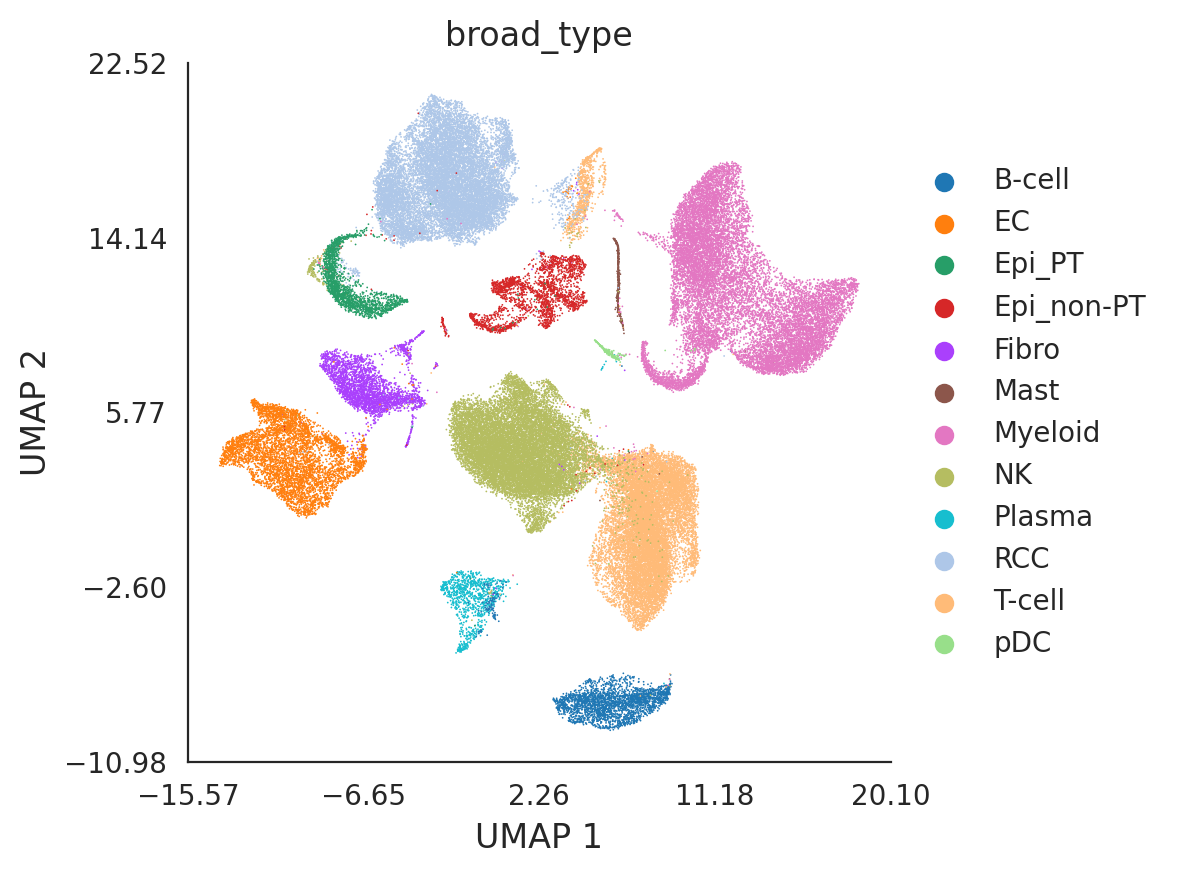

In [113]:
fig = sc.pl.embedding(
    adata,
    show=False,
    basis="umap",
    color='broad_type',
    return_fig=True,
    frameon=False,
)

ax = fig.axes[0]
ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
ax.tick_params(labelsize=10, direction='out', length=4, width=1)
ax.axis("on")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

plt.tight_layout()
plt.savefig('20250531_toal_umap_broad_type_harmonized.png', dpi=300)
plt.show()

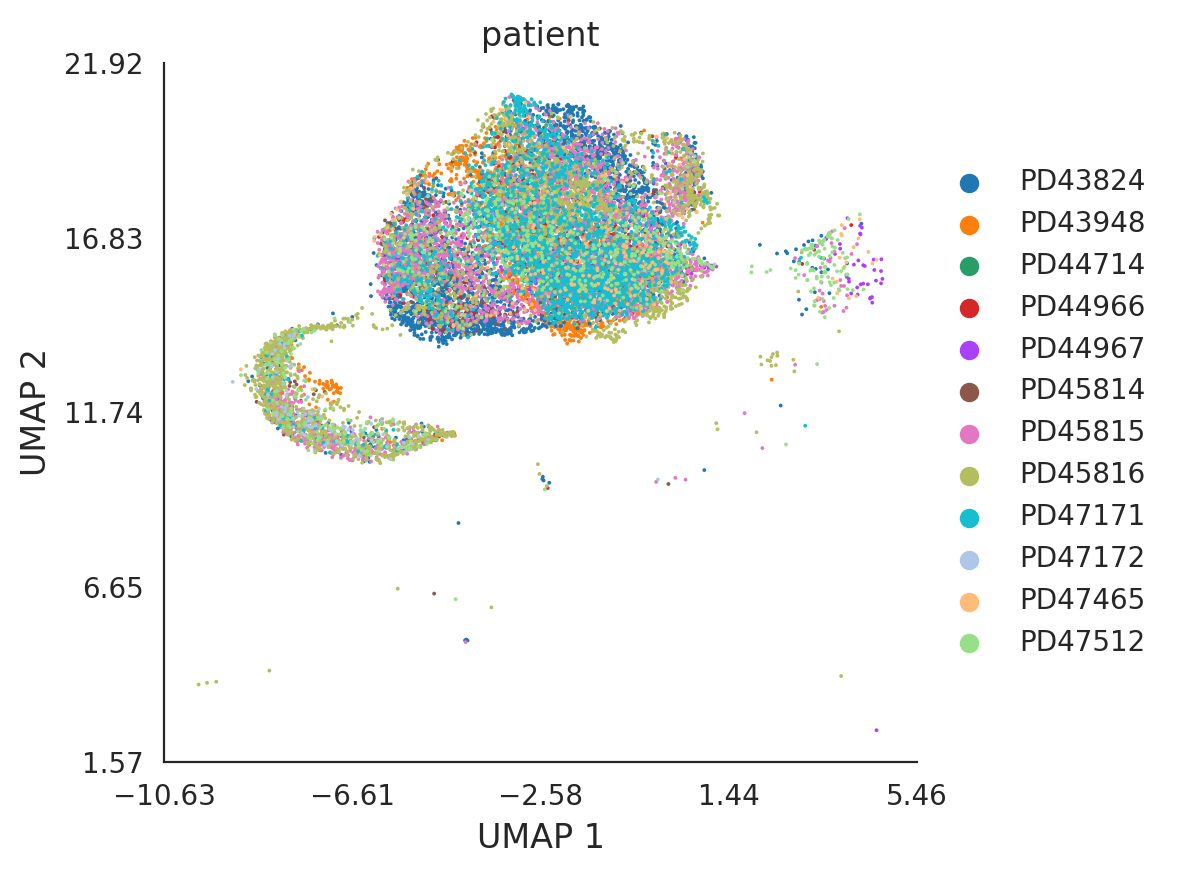

In [116]:
# select RCC and Epi
want = ['RCC','Epi_PT']
adata_renal = adata[adata.obs['broad_type'].isin(want)].copy()

umap_coords =  adata_renal.obsm['X_umap']
x, y = umap_coords[:, 0], umap_coords[:, 1]
keep_mask = (x >= -15) & (x <= 5) & (y >= 0) & (y <= 50)
adata_renal_filtered = adata_renal[keep_mask].copy()

fig = sc.pl.embedding(
    adata_renal_filtered,
    basis="umap",
    color='patient',
    frameon=False,
    show=False,
    return_fig=True
)

ax = fig.axes[0]

ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
ax.tick_params(labelsize=10, direction='out', length=4, width=1)
ax.axis("on")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

plt.tight_layout()
plt.savefig('20250531_renal_umap_patients_harmonized.png', dpi=300)
plt.show()

In [117]:
adata_renal

AnnData object with n_obs × n_vars = 16029 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type', 'tissue_major', 'batch', 'leiden'
    var: 'name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'diffmap_evals', 'leiden', 'patient_colors', 'broad_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_diffmap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [72]:
pd.crosstab(adata_renal.obs['summaryDescription'], 
            adata_renal.obs['broad_type'],
            margins=True)

broad_type,Epi_PT,RCC,All
summaryDescription,,,
Metastasis,0,893,893
Normal kidney,1651,0,1651
Tumour,0,11915,11915
Tumour-normal,252,1318,1570
All,1903,14126,16029


In [73]:
# To infer cluster-specific GRNs, CellOracle requires a base GRN. - There are several ways to make a base GRN.
base_GRN = co.data.load_human_promoter_base_GRN()
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Data not found in the local folder. Loading data from github. Data will be saved at /home/hjlee/celloracle_data/promoter_base_GRN


  0%|          | 0.00/5.26M [00:00<?, ?B/s]

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100027907_100029007,LOXL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100154964_100156064,MIR1287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100174878_100175978,PYROXD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100191017_100192117,MIR4685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100205078_100206178,LOC101927278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# Make Oracle object
# Oracle object during the data preprocessing and GRN inference steps
oracle = co.Oracle()
# Check data in anndata
print("Metadata columns :", list(adata_renal.obs.columns))
print("Dimensional reduction: ", list(adata_renal.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'summaryDescription', 'annotation', 'region', 'broad_type', 'tissue_major', 'batch', 'leiden']
Dimensional reduction:  ['X_pca', 'X_umap', 'X_pca_harmony', 'X_diffmap']


In [119]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata_renal.X = adata_renal.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata_renal,
                                   cluster_column_name="broad_type",
                                   embedding_name="X_umap")

In [82]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)